In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import permutation_importance
from scipy.stats import loguniform
import glob
import os
import time

In [35]:
train_path = max(glob.glob('./data/train/*.csv'), key=os.path.getctime) 
df = pd.read_csv(train_path)
test_path = max(glob.glob('./data/test/*.csv'), key=os.path.getctime) 
test = pd.read_csv(test_path)


In [36]:
scaler = MinMaxScaler() 
df[['reward_tiers', 'min_reward', 'max_reward', 'goal']] = scaler.fit_transform(df[['reward_tiers', 'min_reward', 'max_reward', 'goal']])
test[['reward_tiers', 'min_reward', 'max_reward', 'goal']] = scaler.transform(test[['reward_tiers', 'min_reward', 'max_reward', 'goal']])

<h1>Get to the correct data format</h1>

In [37]:
X_train, y_train = df.drop('state', axis=1), df['state']
X_test, y_test = test.drop('state', axis=1), test['state']

In [38]:
X_train.dtypes.unique()

array([dtype('float64'), dtype('int64')], dtype=object)

<h3>Training using Logisitic Regression Model</h3>

In [39]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(24756, 575)
(24756,)
(4369, 575)
(4369,)


In [40]:
LRModel = LogisticRegression()
LRModel.fit(X_train, y_train)
# Train set
LRModel_train_score = LRModel.score(X_train, y_train)
print('Train Set Accuracy Score: ', LRModel_train_score)
pred = LRModel.predict(X_train)
print("Train Set Confusion Matrix \n", confusion_matrix(y_train, pred))
print("Train Set",classification_report(y_train, pred))

area_under_curve_train = metrics.roc_auc_score(y_train, pred)
print("Area Under Curve:", area_under_curve_train)

#Test Set
LRModel_test_score = LRModel.score(X_test, y_test)
print('Test Set Accuracy Score: ', LRModel_test_score)
test_pred = LRModel.predict(X_test)
print("Test Set Confusion Matrix \n", confusion_matrix(y_test, test_pred))
print("Test Set",classification_report(y_test, test_pred))

area_under_curve_test = metrics.roc_auc_score(y_test, test_pred)
print("Area Under Curve:", area_under_curve_test)

Train Set Accuracy Score:  0.8565600258523186
Train Set Confusion Matrix 
 [[ 4984  2290]
 [ 1261 16221]]
Train Set               precision    recall  f1-score   support

           0       0.80      0.69      0.74      7274
           1       0.88      0.93      0.90     17482

    accuracy                           0.86     24756
   macro avg       0.84      0.81      0.82     24756
weighted avg       0.85      0.86      0.85     24756

Area Under Curve: 0.8065243791980607
Test Set Accuracy Score:  0.8564888990615701
Test Set Confusion Matrix 
 [[ 872  410]
 [ 217 2870]]
Test Set               precision    recall  f1-score   support

           0       0.80      0.68      0.74      1282
           1       0.88      0.93      0.90      3087

    accuracy                           0.86      4369
   macro avg       0.84      0.80      0.82      4369
weighted avg       0.85      0.86      0.85      4369

Area Under Curve: 0.8049462114539003


## Hyper parameter tuning

In [ ]:
#using repeatedStratifiedKfold 
model = LogisticRegression()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=999)
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2']
space['C'] = loguniform(1e-5, 100)

#define search
search = RandomizedSearchCV(model, space, n_iter=10, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=999)

# execute search
result = search.fit(X_train, y_train)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

#Best Score: 0.9194866978270299
# Best Hyperparameters: 
#     {'C': 0.02071613012624668, 'penalty': 'l2', 'solver': 'newton-cg'}

In [9]:
#define models and parameters for Logistic Regression
#don't run this cell, takes around 8 hours to complete
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'saga']
penalty = ['l1','l2', 'none']
c_values = 10. ** np.arange(-3,8)

#define grid seach
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='auc',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

#results 
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
#Best: 0.903942 using {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'}

Best: 0.903942 using {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 0.001, 'penalty': 'l1', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 0.001, 'penalty': 'l1', 'solver': 'lbfgs'}
0.763963 (0.005961) with: {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
0.763936 (0.005936) with: {'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}
0.787351 (0.006397) with: {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
0.791620 (0.006083) with: {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
0.793572 (0.006206) with: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
0.764259 (0.005873) with: {'C': 0.001, 'penalty': 'l2', 'solver': 'saga'}
0.902784 (0.005349) with: {'C': 0.001, 'penalty': 'none', 'solver': 'newton-cg'}
0.844872 (0.012824) with: {'C': 0.001, 'penalty': 'none', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 0.001, 'penalty': 'none', 'solver': 'liblinear'}
0.764286 (0.005868) with: {'C': 0.001, 'penalty': 'none', 'solver': 'saga'

<h3> Testing with training model output </h3>

In [42]:
best_clf = LogisticRegression(**result.best_params_)
start_time = time.time()

best_clf.fit(X_train, y_train)
y_pred_test = best_clf.predict(X_test)

time_taken = time.time() - start_time
print("Total time taken for the program execution", time_taken) # seconds
print(classification_report(y_test, y_pred_test, digits=5))
roc_auc_score(y_test, y_pred_test)

Total time taken for the program execution 11.360604524612427
              precision    recall  f1-score   support

           0    0.85562   0.68877   0.76318      1282
           1    0.88043   0.95173   0.91469      3087

    accuracy                        0.87457      4369
   macro avg    0.86803   0.82025   0.83894      4369
weighted avg    0.87315   0.87457   0.87024      4369



0.8202503124420409

In [32]:
# Best Score: 0.9194866978270299
# Best Hyperparameters: 
# {'C': 0.02071613012624668, 'penalty': 'l2', 'solver': 'newton-cg'}

best_model = LogisticRegression(C=0.02071613012624668, penalty='l2', solver='newton-cg')
best_model.fit(X_train, y_train)
# Train set
best_model_train_score = best_model.score(X_train, y_train)
print('Train Set Accuracy Score after tuning: ', best_model_train_score)
pred1 = best_model.predict(X_train)
print("Train Set Confusion Matrix \n", confusion_matrix(y_train, pred1))
print("Train Set",classification_report(y_train, pred1))

area_under_curve_train = metrics.roc_auc_score(y_train, pred1)
print("Area Under Curve after tuning:", area_under_curve_train)

#Test Set
best_model_test_score = best_model.score(X_test, y_test)
print('Test Set Accuracy Score: ', best_model_test_score)
test_pred1 = best_model.predict(X_test)
print("Test Set Confusion Matrix \n", confusion_matrix(y_test, test_pred1))
print("Test Set",classification_report(y_test, test_pred1))

area_under_curve_test = metrics.roc_auc_score(y_test, test_pred1)
print("Area Under Curve:", area_under_curve_test)

Train Set Accuracy Score after tuning:  0.874414283406043
Train Set Confusion Matrix 
 [[ 4989  2285]
 [  824 16658]]
Train Set               precision    recall  f1-score   support

           0       0.86      0.69      0.76      7274
           1       0.88      0.95      0.91     17482

    accuracy                           0.87     24756
   macro avg       0.87      0.82      0.84     24756
weighted avg       0.87      0.87      0.87     24756

Area Under Curve after tuning: 0.8193666390100072
Test Set Accuracy Score:  0.8745708400091554
Test Set Confusion Matrix 
 [[ 883  399]
 [ 149 2938]]
Test Set               precision    recall  f1-score   support

           0       0.86      0.69      0.76      1282
           1       0.88      0.95      0.91      3087

    accuracy                           0.87      4369
   macro avg       0.87      0.82      0.84      4369
weighted avg       0.87      0.87      0.87      4369

Area Under Curve: 0.8202503124420409


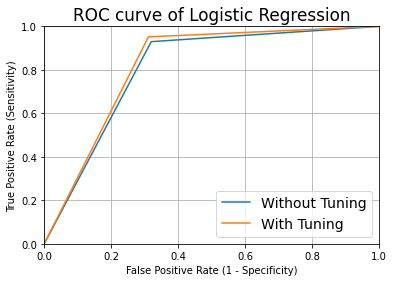

In [33]:
import matplotlib.pyplot as plt
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_pred)
plt.plot(fpr, tpr, label = "Without Tuning")
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, test_pred1)
plt.plot(fpr1, tpr1, label = "With Tuning")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 14
plt.title('ROC curve of Logistic Regression')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
plt.grid(True)

### Run Time

In [26]:
%%time
start_time = time.time()
model_time = LogisticRegression(C=0.02071613012624668, penalty='l2', solver='newton-cg')
model_time.fit(X_train, y_train)
test_pred1 = model_time.predict(X_test)
print("Execution time: " + str((time.time() - start_time)) + ' s')

Execution time: 12.638697624206543 s
Wall time: 12.6 s


### Feature Importance

In [27]:
imps = permutation_importance(model_time, X_test, y_test)
imps_sorted = imps.importances_mean.argsort()[::-1]

print(np.take(X_train.columns, imps_sorted[: 20]))

Index(['staff_pick', 'rewards_word_count', 'rewards_0', 'rewards_1',
       'funding_duration_in_days', 'x0_food', 'x0_film & video', 'rewards_2',
       'rewards_3', 'x0_art', 'rewards_98', 'rewards_99', 'rewards_31',
       'x0_design', 'description_1', 'description_story_27', 'x0_theater',
       'description_risks_66', 'x0_journalism', 'description_70'],
      dtype='object')
